In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom
import numpy

def match_colorbar(ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-5 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = numpy.zeros(img.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    print('Fitted',a,b,c)
    #for k in range(n):
    #    new[y[k], x[k]] = img[ y[k], x[k]] - ( a*x[k] + b*y[k] + c )
    return new, a,b,c

N=256

# img = sscPhantom.mario.createMario(shape=N, noise=False, zoom=0.5)

params = { 'HowMany': 10,
           'radius': 0.07,
           'Rtorus': 0.5,
           'rtorus': 0.1}

nproc  = 16
energy = 7  #Kev
phantom1, phantom2 = sscPhantom.donuts.createDonuts( 128, nproc, energy, params )
phantom = phantom1 + phantom2
img = phantom[:,phantom.shape[1]//2,:]


# Load an image as a floating-point grayscale
image0 = img_as_float(img)
image0 = exposure.rescale_intensity(image0, out_range=(0, 4 * np.pi))
# image0 = np.exp(1j*image0)

x = np.linspace(0,image0.shape[0]-1,image0.shape[0])
X, Y = np.meshgrid(x,x)
a=0.1
b=0.2
c=2
plane = a*X+b*Y +c
image = image0 + plane

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


--> ssc-phantom: particles generated / elapsed: 41.761754274368286
sscPhantom: creating 2 128x128x128 shared arrays (Phantom)
Done: 128 images within 0.7457044124603271 sec
--> ssc-phantom: donuts created / elapsed: 0.7459430694580078


In [ ]:
from PIL import Image
image = Image.open('SS3.png').convert('L')
image = np.asarray(image)
x = np.linspace(0,image.shape[0]-1,image.shape[0])
y = np.linspace(0,image.shape[1]-1,image.shape[1])
X, Y = np.meshgrid(y,x)
a=0.1
b=0.2
c=1
plane = a*X+b*Y +c
image1 = image + plane


figure, ax = plt.subplots(1,4,figsize=(10,4),dpi=300)
ax[0].imshow(image,cmap='gray'), ax[0].set_title("Siemens")
ax[2].imshow(image1,cmap='gray'), ax[2].set_title("Siemens + Plane")
ax[1].imshow(unwrap_phase(np.angle(np.exp(1j*image))),cmap='gray'), ax[1].set_title("Wrap -> Unwrap")
ax[3].imshow(unwrap_phase(np.angle(np.exp(1j*image1))),cmap='gray'), ax[3].set_title("Wrap -> Unwrap")
for ax in ax.ravel(): ax.set_xticks([]),ax.set_yticks([])

Fitted 0.10160078583918365 0.2014142303473191 -4.9127397410596245
0.10160078583918365 0.2014142303473191 -4.9127397410596245


Text(0.5, 1.0, 'Error')

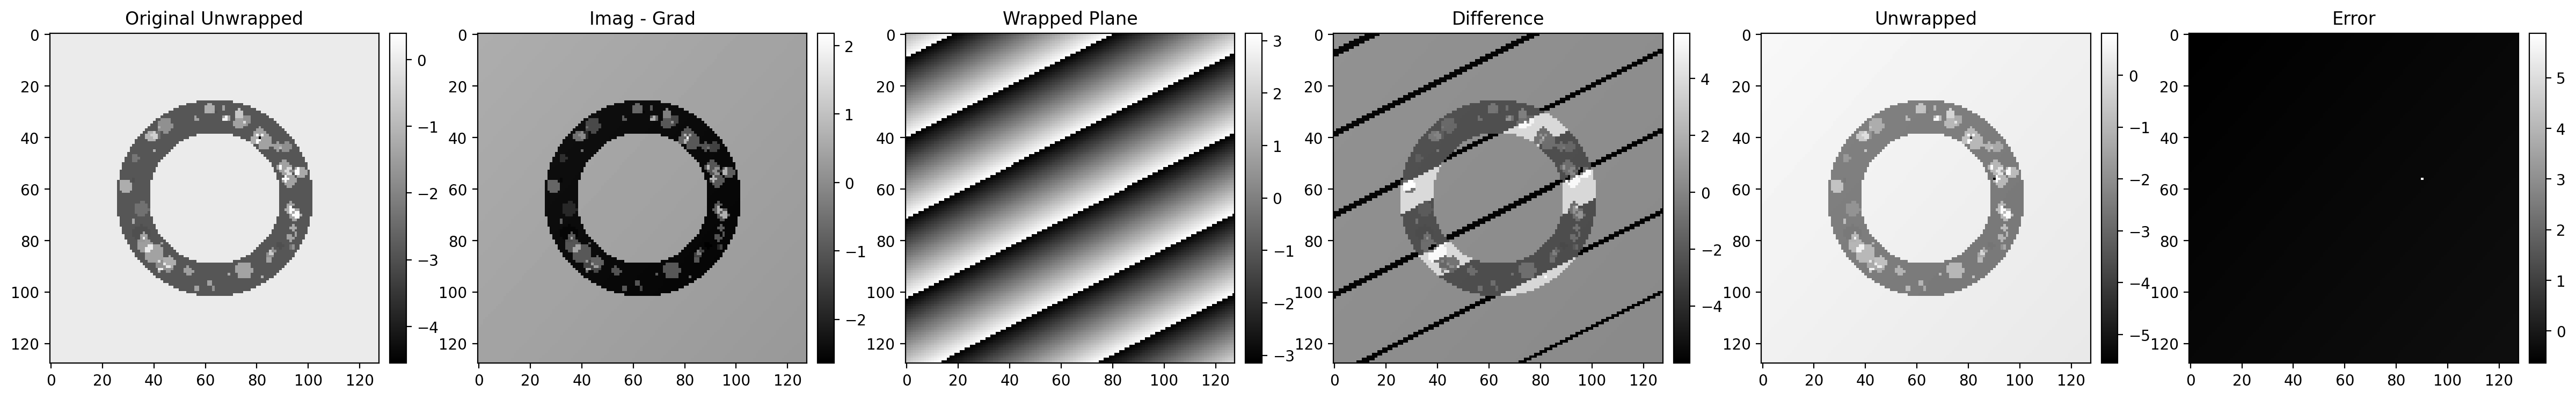

In [3]:
def function(variables,u,v,a):
    Xmesh,Ymesh = variables
    return np.ravel(u*Xmesh+v*Ymesh+a)

from skimage.restoration import unwrap_phase

A,B,C = a,b,c

# Create a phase-wrapped image in the interval [-pi, pi)
image_wrapped = np.angle(np.exp(1j * image))
mask = np.zeros_like(image,dtype=bool)
mask[0:35,0:35] = True


""" Unwrap phase """
image_unwrapped = unwrap_phase(image_wrapped)
# image_unwrapped -= np.min(image_unwrapped)

""" Remove Gradient """
mask2 = ~mask
# mask2 = np.ones_like(mask2,dtype=bool)
image_grad_remove,a,b,c = RemoveGrad_new(image_unwrapped,mask2)
# image_grad_remove -= np.min(image_grad_remove)
print(a,b,c)

x = np.linspace(0,image_unwrapped.shape[0]-1,image_unwrapped.shape[0])
Xmesh, Ymesh = np.meshgrid(x,x)
fit0 = function((Xmesh,Ymesh),a,b,c)
fit0 = fit0.reshape(Xmesh.shape)
# fit0 = plane

wrapped_plane = np.angle(np.exp(1j*fit0))
image_grad_remove2 = image_unwrapped - fit0

wrapped_nobkg = image_wrapped-wrapped_plane
# wrapped_nobkg += np.pi
# wrapped_nobkg = np.angle(np.exp(1j*wrapped_nobkg))

unwrapped2 = unwrap_phase(wrapped_nobkg)

fig, ax = plt.subplots(1, 6, dpi=200, figsize=(30,30))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()
fig.colorbar(ax1.imshow(image0, cmap='gray'), cax=match_colorbar(ax1))
ax1.set_title('Original')
fig.colorbar(ax2.imshow(image, cmap='gray'), cax=match_colorbar(ax2))
ax2.set_title('Original + Plane')
fig.colorbar(ax3.imshow(image_wrapped, cmap='gray', vmin=-np.pi, vmax=np.pi), cax=match_colorbar(ax3))
ax3.set_title('Wrapped phase')
fig.colorbar(ax4.imshow(image_unwrapped, cmap='gray'), cax=match_colorbar(ax4))
ax4.set_title('After unwrapping')
fig.colorbar(ax5.imshow(image_grad_remove, cmap='gray'), cax=match_colorbar(ax5))
ax5.set_title('Gradient Removed')
fig.colorbar(ax6.imshow(image0 - image_grad_remove2, cmap='gray'), cax=match_colorbar(ax6))
ax6.set_title('Error')

original_unwrapped =  unwrap_phase(np.angle(np.exp(1j*image0)))
# original_unwrapped = np.angle(np.exp(1j*unwrap_phase(np.angle(np.exp(1j*image0))-np.pi))
# original_unwrapped = np.angle(np.exp(1j*image0))

fig, ax = plt.subplots(1, 6, dpi=200, figsize=(30,30))
ax1, ax4, ax6,ax7,ax8,ax9 = ax.ravel()
fig.colorbar(ax1.imshow(original_unwrapped, cmap='gray'), cax=match_colorbar(ax1))
ax1.set_title('Original Unwrapped')
fig.colorbar(ax4.imshow(image_grad_remove2, cmap='gray'), cax=match_colorbar(ax4))
ax4.set_title('Imag - Grad')
fig.colorbar(ax6.imshow(wrapped_plane, cmap='gray', vmin=-np.pi, vmax=np.pi), cax=match_colorbar(ax6))
ax6.set_title('Wrapped Plane')
fig.colorbar(ax7.imshow(wrapped_nobkg, cmap='gray'), cax=match_colorbar(ax7))
ax7.set_title('Difference')
fig.colorbar(ax8.imshow(unwrapped2, cmap='gray'), cax=match_colorbar(ax8))
ax8.set_title('Unwrapped')
fig.colorbar(ax9.imshow(original_unwrapped - unwrapped2, cmap='gray'), cax=match_colorbar(ax9))
ax9.set_title('Error')



## Gauss-Newton

0.1 0.2 2
0.997597898823724 0.9180783007441097 1.2300050569472845


Text(0.5, 1.0, 'Corrected')

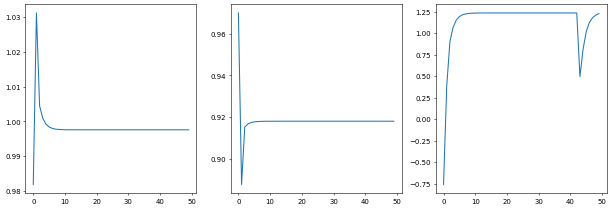

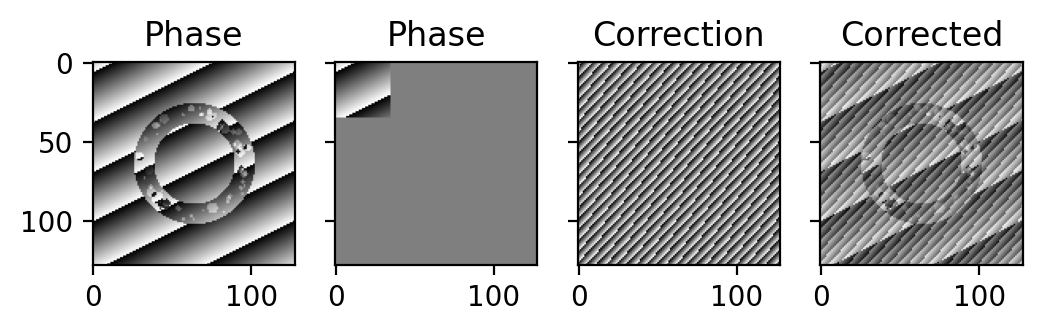

In [4]:
# Gauss-Newton

phase = image_wrapped
initial_guess = (1,1,1)

img_shape = image_wrapped.shape
x_values = np.linspace(0,img_shape[0]-1,img_shape[0])
y_values = np.linspace(0,img_shape[1]-1,img_shape[1])
Xmesh, Ymesh = np.meshgrid(x_values,y_values)
Xmesh, Ymesh = X, Y

def argument(mask,phase,Xmesh,Ymesh,u,v,a):
    return phase -(u*Xmesh+v*Ymesh+a)

def jacobian(mask,phase,Xmesh,Ymesh,u,v,a):
    A = np.sum(mask*np.sin(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    B = np.sum(mask*Xmesh*np.sin(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    C = np.sum(mask*Ymesh*np.sin(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    return -4*np.array([B,C,A],dtype=float)
                        
def hessian(mask,phase,Xmesh,Ymesh,u,v,a):
    A = np.sum(mask*Xmesh**2*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    B = np.sum(mask*Xmesh*Ymesh*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    C = np.sum(mask*Xmesh*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    E = np.sum(mask*Ymesh**2*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    F = np.sum(mask*Ymesh*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    I = np.sum(mask*np.cos(argument(mask,phase,Xmesh,Ymesh,u,v,a)))
    D = B
    G = C
    H = F
    return 4*np.array([[A,B,C],[D,E,F],[G,H,I]])

u, v, a = initial_guess
u_list,v_list,a_list = [], [] ,[]
for i in range(50):
    vector = -np.linalg.pinv(hessian(mask,phase,Xmesh,Ymesh,u,v,a))@jacobian(mask,phase,Xmesh,Ymesh,u,v,a)
    du, dv, da = vector
    u, v, a = u+du, v+dv, a+da
    u_list.append(u)
    v_list.append(v)
    a_list.append(a)

print(A,B,C)
print(u,v,a)
    
figure, ax = plt.subplots(1,3,dpi=50,figsize=(15,5))
ax1, ax2, ax3  = ax.ravel()
ax1.plot(np.array(u_list))
# ax1.axhline(A,linestyle='--',color='red')
ax2.plot(np.array(v_list))
# ax2.axhline(B,linestyle='--',color='red')
ax3.plot(np.array(a_list))
# ax3.axhline(C,linestyle='--',color='red')
# for axs in ax.ravel():
    # axs.set_ylim(-3,3)

phase_correction = np.angle(np.exp(1j*(u*Xmesh+v*Ymesh+a)))
corrected_phase = phase - phase_correction

fig, ax = plt.subplots(1, 4, dpi=200,sharex=True, sharey=True)
ax1, ax4, ax2, ax3  = ax.ravel()
ax1.imshow(phase, cmap='gray')
ax1.set_title('Phase')
ax4.imshow(phase*mask, cmap='gray')
ax4.set_title('Phase')
ax2.imshow(phase_correction, cmap='gray')
ax2.set_title('Correction')
ax3.imshow(corrected_phase, cmap='gray')
ax3.set_title('Corrected')

## Minimize

(1225,)


Text(0.5, 1.0, 'Fit')

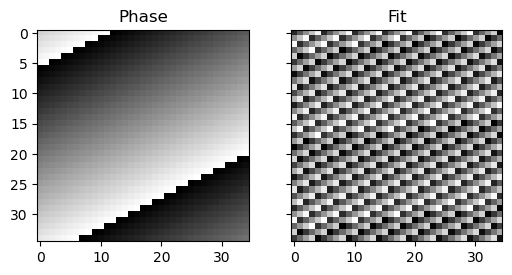

In [5]:
from scipy.optimize import curve_fit

def function(variables,u,v,a):
    Xmesh,Ymesh = variables
    return np.ravel(np.angle(np.exp(-1j*(u*Xmesh+v*Ymesh+a))))

phase_true = phase[mask==True].copy()
print(phase_true.shape)
size = int(np.sqrt(phase_true.shape[0]))
phase_true = phase_true.reshape((size,size))
Xmesh = X[mask==True].reshape((size,size))
Ymesh = Y[mask==True].reshape((size,size))

size_to_reshape = Xmesh.shape
fit_guess = (5,10,1.9)
params, pcov = curve_fit(function, (Xmesh, Ymesh), np.ravel(phase_true), fit_guess)
fit = function((Xmesh,Ymesh),params[0],params[1],params[2])
fit = fit.reshape(size_to_reshape)

fig, ax = plt.subplots(1, 2, dpi=100,sharex=True, sharey=True)
ax1, ax2 = ax.ravel()
ax1.imshow(phase_true, cmap='gray')
ax1.set_title('Phase')
ax2.imshow(fit,cmap='gray')
ax2.set_title('Fit')

## FFT

(array([138, 138]), array([111, 165]))
[0. 0.] [-4.98913043  4.98913043]


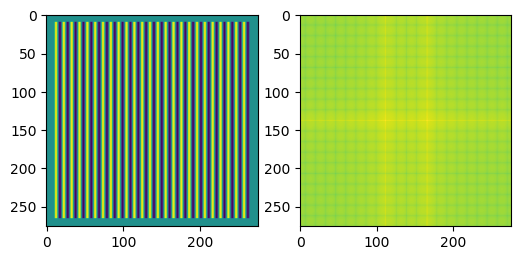

In [6]:
#TEST
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

N = 256
x = np.linspace(0,5,N)
dx = x[1]-x[0]
X, Y = np.meshgrid(x,x)

f = 5
image = np.sin(2*np.pi*f*X)
n = 10
image = np.pad(image,[(n,n),(n,n)])

ft = np.fft.fft2(image)
freq = np.fft.fftfreq(image.shape[0],dx)
ft = np.fft.fftshift(ft)
freq = np.fft.fftshift(freq)

maximum = np.max(np.abs(ft))
idx_max = np.where(np.abs(ft)==maximum)
print(idx_max)
print(freq[idx_max[0]],freq[idx_max[1]])

figure, ax = plt.subplots(1,2,dpi=100)
ax1, ax2 = np.ravel(ax)
ax1.imshow(image)
ax2.imshow(np.abs(ft),norm=LogNorm())

(array([7052]), array([7190]))
100 20 2
0.78125 0.15625 2
0.7827217670110438 0.15835411471321698 2
100.1883861774136 20.269326683291773 2
6.269777607073868 -0.04493585502017439 6.314713462094042 6.283185307179586


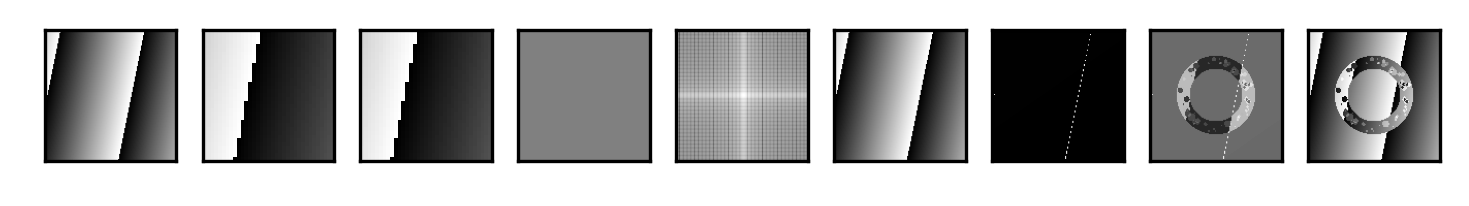

In [7]:
x = np.linspace(0,2,image0.shape[0])
Xmesh, Ymesh = np.meshgrid(x,x)
dx = x[1]-x[0]

A,B,C = 100, 20, 2

plane = 2*np.pi*A*Xmesh/Xmesh.shape[0] + 2*np.pi*B*Ymesh/Ymesh.shape[1] + C
image = image0 + plane
# image = plane

phase_true = np.angle(np.exp(1j*image))[mask==True].copy()
size = int(np.sqrt(phase_true.shape[0]))
phase_true = phase_true.reshape((size,size))

n=200
phase_true = np.exp(1j*phase_true)
phase = np.pad(phase_true,[[n*phase_true.shape[0],n*phase_true.shape[1]],[n*phase_true.shape[0],n*phase_true.shape[1]]])

DFT = np.fft.fft2(phase)
DFT = np.fft.fftshift(DFT)
freq_r = np.fft.fftfreq(phase.shape[0],dx)
freq_r = np.fft.fftshift(freq_r)

maximum = np.max(np.abs(DFT))
idx_max = np.where(np.abs(DFT) == maximum)

# u,v,a = freq_r[idx_max[1]][0],freq_r[idx_max[0]][0],np.angle(DFT[idx_max[0],idx_max[1]][0])
u,v,a = freq_r[idx_max[1]][0],freq_r[idx_max[0]][0],C
# u,v,a = A/Xmesh.shape[0],B/Xmesh.shape[0],C
# u,v,a = 0.781, 0.156, 2

gradient = np.exp(1j*2*np.pi*(u*Xmesh + v*Ymesh)+1j*a)
gradient = np.angle(gradient)
diff = np.angle(np.exp(1j*plane))-gradient

diff2 = np.angle(np.exp(1j*image)) - gradient

print(idx_max)
print(A,B,C)
print(A/Xmesh.shape[0],B/Ymesh.shape[1],C)
print(u,v,a)
print(u*Xmesh.shape[0],v*Xmesh.shape[0],a)
print(np.max(diff),np.min(diff),np.max(diff)-np.min(diff),2*np.pi)

""" Plots """
fig, ax = plt.subplots(1, 9, dpi=300)
ax0, ax1, ax2, ax3, ax4,ax5, ax6, ax7, ax8 = ax.ravel()
for ax in ax.ravel(): ax.set_xticks([]), ax.set_yticks([])
ax0.imshow(np.angle(np.exp(1j*plane)), cmap='gray')
ax1.imshow(np.angle(np.exp(1j*plane))[mask==True].reshape((size,size)), cmap='gray')
ax2.imshow(np.angle(phase_true), cmap='gray')
ax3.imshow(np.angle(phase), cmap='gray')
ax4.imshow(np.abs(DFT), cmap='gray',norm=LogNorm())
ax5.imshow(gradient, cmap='gray')
ax6.imshow(diff, cmap='gray')
ax7.imshow(diff2, cmap='gray')
ax8.imshow(np.angle(np.exp(1j*image)), cmap='gray')

In [8]:
shape = (10,11,13)
sinogram = np.ones(shape)

if sinogram.shape[1]%2!=0:
    sinogram = sinogram[:,0:-1,:]
if sinogram.shape[2]%2!=0:
    sinogram = sinogram[:,:,0:-1]
    
sinogram.shape

(10, 10, 12)

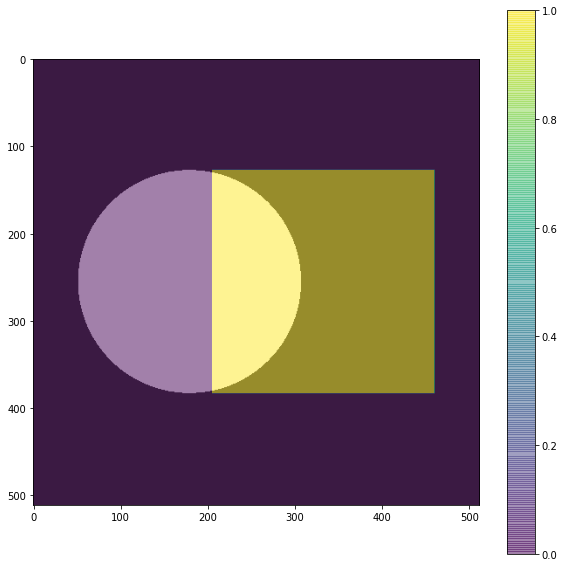

In [9]:
t = numpy.linspace(-1,1,512)
x,y = numpy.meshgrid(t,t)
img1 = (x+0.3)**2 + (y)**2 < 0.5**2
img2 = numpy.maximum( abs(x-0.3), abs(y)) < 0.5
plt.figure(figsize=(10,10))
plt.imshow(img1, alpha=0.8, cmap=plt.cm.gray)
plt.imshow(img2, cmap=plt.cm.viridis, alpha=.5)
plt.colorbar()